# A Movie behind a Script


In [1]:
import os
import re
import pandas as pd
#from datetime import datetime
#import urllib.request

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf
from pyspark.sql.utils import AnalysisException

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Overview of datasets

The OpenSubtitles dataset is a compressed cluster of folders containing XML files. Each XML file is split into a script portion with the subtitles of the movie and a metadata portion with additional information about the movie or show. The name of one of the parent folders of the XML file is the corresponding IMDb identifier of the movie or show, thus allowing us to extract additional information from the IMDb dataset.

## IMDb Dataset

We have at our disposal the IMDb ratings and basics dataset. 

In [3]:
# TODO scrape data https://datasets.imdbws.com/
ratings_fn = "title.ratings.tsv.gz"
basics_fn = "title.basics.tsv.gz"

In [4]:
df_ratings = spark.read.option("header", "true")\
                       .option("sep", "\t")\
                       .csv("imdb_data/" + ratings_fn)
df_ratings = df_ratings.selectExpr("tconst", 
                                   "cast(averageRating as float) averageRating", 
                                   "cast(numVotes as int) numVotes")
df_ratings.show()

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1440|
|tt0000002|          6.3|     172|
|tt0000003|          6.6|    1041|
|tt0000004|          6.4|     102|
|tt0000005|          6.2|    1735|
|tt0000006|          5.5|      91|
|tt0000007|          5.5|     579|
|tt0000008|          5.6|    1539|
|tt0000009|          5.6|      74|
|tt0000010|          6.9|    5127|
|tt0000011|          5.4|     214|
|tt0000012|          7.4|    8599|
|tt0000013|          5.7|    1318|
|tt0000014|          7.2|    3739|
|tt0000015|          6.2|     660|
|tt0000016|          5.9|     982|
|tt0000017|          4.8|     197|
|tt0000018|          5.5|     414|
|tt0000019|          6.6|      13|
|tt0000020|          5.1|     232|
+---------+-------------+--------+
only showing top 20 rows



In [5]:
# writting into a .parquet file : 
# df_ratings.write.mode('overwrite').parquet('ratings.parquet')

In [6]:
# Function to split genres
udf_split = psf.udf(lambda s: s.split(',') if s is not None else "", ArrayType(StringType()))

df_basics = spark.read.option("header", "true")\
                      .option("sep", "\t")\
                      .csv("imdb_data/" + basics_fn)
df_basics = df_basics.withColumn("rttmp", df_basics.runtimeMinutes.cast(DoubleType()))\
                     .drop("runtimeMinutes")\
                     .withColumnRenamed("rttmp", "runtimeMinutes")\
                     .withColumn("gtmp", udf_split("genres"))\
                     .drop("genres")\
                     .withColumnRenamed("gtmp", "genres")
df_basics.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|           1.0|[Documentary, Short]|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|           5.0|  [Animation, Short]|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|           4.0|[Animation, Comed...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|          null|  [Animation, Short]|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|           1.0|     [Comedy, 

In [7]:
# writting into a .parquet file : 
# df_basics.write.mode('overwrite').parquet('basics.parquet')

## OpenSubtitles dataset

The dataset consists of 31 GB of XML files distributed in the following file structure: 

```
├── opensubtitle
│   ├── OpenSubtitles2018
│   │   ├── Year
│   │   │   ├── Id
│   │   │   │   ├── #######.xml.gz
│   │   │   │   ├── #######.xml.gz
│   ├── en.tar.gz
│   ├── fr.tar.gz
│   ├── zh_cn.tar.gz
```
where
- `######` is a 6-digit unique identifier of the file on the OpenSubtitles dataset.
- `Year` is the year the movie or episode was made.
- `Id` is a 5 to 7 digit identifier (if it's 7-digit it's also an IMDb identifier).

The subtitles are provided in different languages. We only analyze the `OpenSubtitles2018` folder and it's the only folder we detail.

The decompressed XML files vary in size, ranging from 5KB to 9000KB sized files.

## XML Files

Each XML file is split into a `document` and `metadata` section.

### Subtitles

The `document` section contains all the subtitles and its general structure is the following:

```
├── s
│   ├── time: Integer
│   ├── w: String
```

An example snippet of an XML file:

```xml
  <s id="1">
    <time id="T1S" value="00:00:51,819" />
    <w id="1.1">Travis</w>
    <w id="1.2">.</w>
    <time id="T1E" value="00:00:53,352" />
  </s>
```

The subtitles in each XML file are stored by **blocks** denoted by `s` with a unique `id` attribute (integers in increasing order starting at 1).  

Each block (`<s id="1">` for instance) has a:  

1. Set of timestamps (denoted by `time`) with
 - A timestamp `id` attribute that can take two different formats: `T#S` or `T#E`, where _S_ indicates _start_, _E_ indicates _end_ and _#_ is an increasing integer. 
 - A `value` attribute which has the format `HH:mm:ss,fff`.

2. Set of words (denoted by `w`) with
 - an `id` attribute that is simply an increasing number of decimal numbers of the format `X.Y` where X is the string id and Y is the word id within the corresponding string
 - a non-empty `value` attribute that contains a token: a word or a punctuation character. 

It sometimes also has an `alternative`, `initial` and `emphasis` attribute.  

 - The `initial` attribute generally corresponds to slang words or mispronounced words because of an accent such as _lyin'_ instead of _lying_.  
 - The `alternative` attribute is another way of displaying the subtitle for example _HOW_ instead of _how_.
 - The `emphasis` attribute is a boolean.

### Metadata

The `metadata` section has the following structure:

```
├── Conversion
│   ├── corrected_words: Integer
│   ├── sentences: Integer
│   ├── tokens: Integer
│   ├── encoding: String (always utf-8)
│   ├── unknown_words: Integer
│   ├── ignored_blocks: Integer
│   ├── truecased_words: Integer
├── Subtitle
│   ├── language: String
│   ├── date: String
│   ├── duration: String
│   ├── cds: String (presented as #/# where # is an int)
│   ├── blocks: Integer
│   ├── confidence: Double
├── Source
│   ├── genre: String[] (up to 3 genres)
│   ├── year: Integer
│   ├── duration: Integer (in minutes)
│   ├── original: String
│   ├── country: String
```

We note that some XML files may not have all the entries. 
We can use the metadata to obtain additional information about the movie or show's subtitles and compute certain statistics. 

## Document dataframe

## Exploration

Going through the dataset we notice a few things:

1. The dataset has meaningless folders. For example, the folder 1858/ is empty.
2. Dataset contains XML files that are not related to movies or TV shows. For example, the folder 666/ contains Justin Bieber song subtitles.  
3. Trailer of films can be present in the dataset. For example, the folder 2018/ we found for example Black Panther teaser trailer subtitles.
4. Each movie might have more than 1 subtitle file.
5. Some subtitle files contain text that is not related to the movie, like credits to the person who made the subtitles.
6. The IDMDb folder name is not always a 7-digit number, meaning it is not always a valid IMDb identifer and we can't retrieve the IMDb info.
7. Each block may have an arbitrary number (including 0) of timestamps associated to it.

To solve points 1 and 2, we ignore all the folders which aren't inside the range of 1920-2018.

To solve point 3, we drop trailers by looking at the `duration` field in the metadata section.

To solve point 4, we simply take the first one.

To solve point 6, we keep movies that have a correct IMDb identifier. Hence, all the files in folders that don't have a 7-digit folder name are dropped.

To solve point 7, we decide not to associate a timestamp to each word for the moment.
 
For the moment, we take a sample of the dataset from the cluster (see python script `extract_sample_2.py`) by collecting 1 or 2 movies for each year in the range 1920-2018.

## Putting it all together

After doing an analysis of the files and considering the statistics we want to obtain taking the size of our data into account, we decide to load the metadata and subtitles directly into 1 dataframe where we manipulate it as before. We decide not to extract all tokens at first as it would induce into very heavy computations. We store the text in an array of subtitles where each subtitle is an array of tokens.

In [8]:
imdb_id = '6464116'
df_document_example = sqlContext.read.format('com.databricks.spark.xml')\
                                     .options(rowTag='document') \
                                     .load('sample_dataset/2017/6464116/6887453.xml.gz')
df_document_example.printSchema()
df_document_example.show()

root
 |-- _id: long (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- conversion: struct (nullable = true)
 |    |    |-- corrected_words: long (nullable = true)
 |    |    |-- encoding: string (nullable = true)
 |    |    |-- ignored_blocks: long (nullable = true)
 |    |    |-- sentences: long (nullable = true)
 |    |    |-- tokens: long (nullable = true)
 |    |    |-- truecased_words: long (nullable = true)
 |    |    |-- unknown_words: long (nullable = true)
 |    |-- source: struct (nullable = true)
 |    |    |-- duration: long (nullable = true)
 |    |    |-- genre: string (nullable = true)
 |    |    |-- year: long (nullable = true)
 |    |-- subtitle: struct (nullable = true)
 |    |    |-- blocks: long (nullable = true)
 |    |    |-- cds: string (nullable = true)
 |    |    |-- confidence: double (nullable = true)
 |    |    |-- date: string (nullable = true)
 |    |    |-- duration: string (nullable = true)
 |    |    |-- language: string (nullable = true)
 

To avoid confusion, we will set some naming conventions. We will refer to certain attributes as follows:

- The `s` array as **blocks**
- An element of blocks, as a **block**.
- The `w` array as **elements**
- An element of elements, as **element**.
- `_VALUE` as a **token**
- A **subtitle** is a list of tokens

### Dataframe manipulation

We define a function that retrieves the tokens from the elements (`w` array) and returns an array of subtitles, where each subtitle is a list of tokens.

In [9]:
def to_subtitles_array(sentences):
    """Function to map the elements (a struct containing tokens)
    to a list of list of tokens """
    s_list = []
    if sentences is None:
        return s_list
    for words in sentences:
        w_list = []
        if words and "w" in words and words["w"]:
            for w in words["w"]:
                if '_VALUE' in w and w['_VALUE']:
                    w_list.append(w['_VALUE'])
                
            s_list.append(w_list)

    return s_list

Here we define a couple of udf functions we will later use for the manipulation of our dataset

In [10]:
# Transform to spark function
udf_subtitles_array = psf.udf(to_subtitles_array, ArrayType(ArrayType(StringType())))
# Convert array of words into a single string
udf_sentence = psf.udf(lambda x: ' '.join(x), StringType())


In [11]:
#checks if correct schema
def has_correct_schema(df):
    arguments = [
                 "meta.conversion.sentences",
                 "meta.source.year", 
                 "meta.subtitle.blocks",
                 "meta.subtitle.duration",
                 "meta.subtitle.language",
                 "s"]
    for col in arguments:
        try:
            df[col]
        except AnalysisException:
            return False
    return True

schema_films = StructType([StructField('tconst', StringType(), False),
                               StructField('num_sentences', LongType(), True),
                               StructField('year', LongType(), True),
                               StructField('blocks', LongType(), True),
                               StructField('subtitle_mins', DoubleType(), True),
                               StructField('subtitles', ArrayType(ArrayType(StringType())), True)])

The function below structures our data to the format we want to then process all the queries we need: We link the movie with the proper imdbID, we get all the subtitles, change the subtitle duration to be in seconds (We assume for this that they all have the same format and after exploring the dataset we know the vast majority does).

In [12]:
has_correct_schema(df_document_example)

True

In [13]:
def clean_df(df_document, imdb_id):
    """Restructures and selects the columns of a dataframe of an XML
    file with its corresponding IMDB Id"""
    # Create IMDb ID and subtitles column
    df_film_sentences = df_document.withColumn("tconst", psf.lit("tt" + imdb_id))\
                                   .withColumn("subtitles", udf_subtitles_array("s"))
    
    # Select metadata and previously created columns
    df_result = df_film_sentences.selectExpr("tconst",
                                             "meta.conversion.sentences as num_sentences",
                                             "meta.source.year", 
                                             "meta.subtitle.blocks",
                                             "meta.subtitle.duration as subtitle_duration",
                                             "meta.subtitle.language",
                                             "subtitles")
    # Split genre column and convert subtitle duration to seconds
    df_result = df_result.withColumn("subtitle_mins", 
                                     psf.unix_timestamp(df_result.subtitle_duration, "HH:mm:ss,SSS") / 60)
    # Discard redundant columns
    return df_result.select("tconst", "num_sentences", "year", "blocks", "subtitle_mins", "subtitles")

Applying it on the example XML file, we see how our corresponding schema is much more simple.

In [14]:
df_document_example = clean_df(df_document_example, imdb_id)
df_document_example.printSchema()
df_document_example.show()

root
 |-- tconst: string (nullable = false)
 |-- num_sentences: long (nullable = true)
 |-- year: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- subtitle_mins: double (nullable = true)
 |-- subtitles: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)

+---------+-------------+----+------+-------------+--------------------+
|   tconst|num_sentences|year|blocks|subtitle_mins|           subtitles|
+---------+-------------+----+------+-------------+--------------------+
|tt6464116|          967|2017|   888|         40.7|[[[, shots, firin...|
+---------+-------------+----+------+-------------+--------------------+



We generalize what we have done so far. We would like to create a dataframe for several XML files, so we define a function that does this.

In [15]:
def load_df(path):
    """Load an XML subtitles file into a dataframe"""
    df_film = sqlContext.read.format('com.databricks.spark.xml')\
                             .options(rowTag='document')\
                             .load(path)
    return df_film

The code below creates a dataframe for all the XML files in the sample dataset. We will later expand it to cover a bigger quantity of films. We call it `df_films` because it contains all the information for each film/show in our datasets.

In [16]:
#path = "sample_dataset/"
# Create empty dataframe with same schema


#df_films = spark.createDataFrame([], schema_films)
#film_list = []
#for year in os.listdir(path):
 #   if not year.startswith('.'):
  #      for imdb_id in os.listdir(path + year):
   #         if not imdb_id.startswith('.'):
    #            current_path = path + year + "/" + imdb_id
     #           for idx, file in enumerate(os.listdir(current_path)):
      #                  # Create a dataframe for each file
       #                 df_document = load_df(current_path + '/' + file)
        #                if has_correct_schema(df_document):
                            # Restructure dataframe and add it to df_films
         #                   film_list.append(clean_df(df_document, imdb_id))
                        

#             df_m.show()
#             print(current_path + "/" + file)

In [17]:
def unionAll(*dfs):
    first, rest = dfs[0], dfs[1:]  # Python 3.x, for 2.x you'll have to unpack manually
    return first.sql_ctx.createDataFrame(
        first.sql_ctx._sc.union([df.rdd for df in dfs]),
        first.schema
    )
#df_films = unionAll(*film_list)

We use the same structure to create dataframes which contain the entries we want to focus on, more specifically movies with more than 5000 reviews. The script can be found under the name `cluster/parquet2.py`. To filter the appropiate files we used the imdb datasets.

In [18]:
df_films = spark.read.parquet("parquets/films.parquet")

In [19]:
# df_list = [spark.read.parquet("parquets/" + path) for path in os.listdir("parquets") if path != ".DS_Store"]

The total films we will be focusing on then is:

In [20]:
# df_films = unionAll(*df_list)
df_films.count()

4286

In [21]:
df_films.show()
df_films.printSchema()

+---------+-------------+----+------+------------------+--------------------+
|   tconst|num_subtitles|year|blocks|     subtitle_mins|           subtitles|
+---------+-------------+----+------+------------------+--------------------+
|tt5275892|         6236|2016|  1829|            406.05|[[As, a, kid, gro...|
|tt2234155|         3562|2013|  3348|63.166666666666664|[[An, old, man, t...|
|tt2318527|         7083|2013|  2793| 32.46666666666667|[[BELL, TOLLING],...|
|tt2404463|         4078|2013|  3356| 60.11666666666667|[[Cleaned, correc...|
|tt3311384|         1993|2013|  2116|59.016666666666666|[[CROWD, CHEERING...|
|tt1398426|         3729|2015|  2768| 86.06666666666666|[[Police, Radio, ...|
|tt4540710|         2018|2016|  1668| 67.23333333333333|[[Subtitle, made,...|
|tt4257858|         1553|2015|  2415|              58.8|[[We, will, begin...|
|tt2080374|         2889|2015|  2309|             62.15|[[MAN], [And, wit...|
|tt4425064|         1807|2015|  1951| 68.61666666666666|[[After,

## Data analysis

Here we discuss how we want to proceed with our data.

We consider only films with more than 5,000 reviews as IMDb considers this a good metric to estimate the public actual approval of a film.

We first start by analyzing the 1000 best films according to IMDB with more that 20000 reviews. We look into the resulting dataframe columns and  try to look for some kind of pattern. We look at: 
- the ratio of subtitle time per runtime, 
- the most used words in the films, 
- the ratio of distinct words per total number of words, 
- average sentence length, 
- number of sentences. 

We draw conclusions if we see any apparent relation. Afterwards if we can find a relation between rating and one of the resulting values, we do the same tests on the worst imdb films with more than 20000 reviews.. If we find that a relation holds for both groups we make a statement assuming there exists a relationship

We know this is very vague and we cannot make a strong statement based on what we find, if we find anything because we don't take into consideration many variables such as the movie genre, the year of release, if it is an adult film or not. Also the country of origin is a variable to take into account but we don't have it yet. We can also check the box office for the best films.

To proceed then, we ask what are the most popular genres and we look into how the statistics for the 10 most popular ones behave. Can we find any relationship between a genre and the statistics. We look aswell for relationships between genre and rating. Is the genre of a movie a variable which influences average rating. 

It is all interconnected, we ask ourselves for example, given an action movie, are the value of the statistics influential to its average rating. 

We havent taken TIME into account either! We look into different time periods, particular years where something occured (WW2 end or smth like that) and we try using the same statistics, to find relationships. We need to choose how to address the other variables such as genre and if it is an adult film or not.

After analyzing this data if we find that there are actually dependencies between the values, we decide to create a small learning algorithm to predict the rating of a film given its script.

In [22]:
def word_statistics(df_films):
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))
    df_word_counts = df_words.groupby("tconst", "num_subtitles", "blocks", "subtitle_mins")\
                             .agg(psf.count("word").alias("Number of words"), 
                                  psf.countDistinct("word").alias("Number of distinct words"))\
                             .withColumn("Mean length of sentences",
                                         psf.col("Number of words") / psf.col("num_subtitles"))\
                             .withColumn("Spread of sentences",
                                         psf.col("num_subtitles") / psf.col("blocks"))
    return df_word_counts

In [23]:
df_word_stats = word_statistics(df_films)
df_word_stats.show()

+---------+-------------+------+------------------+---------------+------------------------+------------------------+-------------------+
|   tconst|num_subtitles|blocks|     subtitle_mins|Number of words|Number of distinct words|Mean length of sentences|Spread of sentences|
+---------+-------------+------+------------------+---------------+------------------------+------------------------+-------------------+
|tt4540710|         2018|  1668| 67.23333333333333|          15560|                    3296|       7.710604558969276|  1.209832134292566|
|tt0058331|         2385|  1049|              73.6|          12521|                    2279|       5.249895178197065|  2.273593898951382|
|tt0076666|         3404|   973|178.01666666666668|          15996|                    1417|       4.699177438307873|  3.498458376156218|
|tt0096969|         2686|  2639|             77.65|          12188|                    1994|       4.537602382725242|  1.017809776430466|
|tt0386588|         1871|  1487|52

## Scatter plots

In [24]:
df_words_ratings = df_word_stats.join(df_ratings, "tconst")
df_words_ratings.show()

+---------+-------------+------+------------------+---------------+------------------------+------------------------+-------------------+-------------+--------+
|   tconst|num_subtitles|blocks|     subtitle_mins|Number of words|Number of distinct words|Mean length of sentences|Spread of sentences|averageRating|numVotes|
+---------+-------------+------+------------------+---------------+------------------------+------------------------+-------------------+-------------+--------+
|tt4540710|         2018|  1668| 67.23333333333333|          15560|                    3296|       7.710604558969276|  1.209832134292566|          7.5|   47445|
|tt0058331|         2385|  1049|              73.6|          12521|                    2279|       5.249895178197065|  2.273593898951382|          7.8|  128871|
|tt0076666|         3404|   973|178.01666666666668|          15996|                    1417|       4.699177438307873|  3.498458376156218|          6.8|   62554|
|tt0096969|         2686|  2639|  

In [26]:
df_words_ratings_pd = df_words_ratings.toPandas()

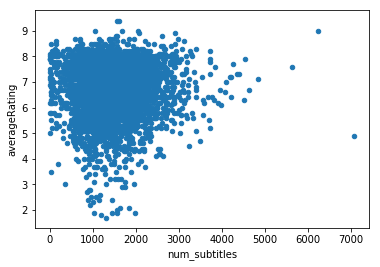

In [31]:
ax = df_words_ratings_pd.plot.scatter("num_subtitles", "averageRating")

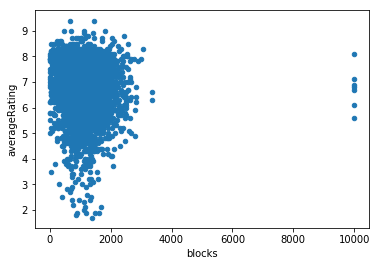

In [32]:
ax = df_words_ratings_pd.plot.scatter("blocks", "averageRating")

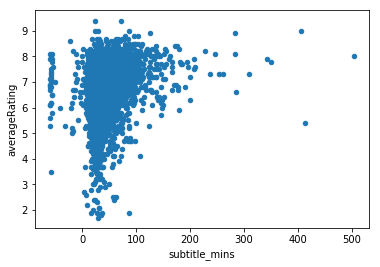

In [33]:
ax = df_words_ratings_pd.plot.scatter("subtitle_mins", "averageRating")

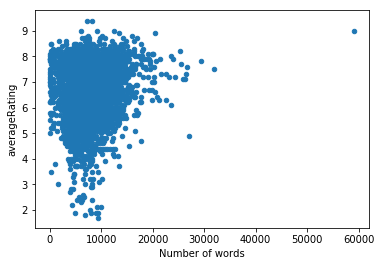

In [34]:
ax = df_words_ratings_pd.plot.scatter("Number of words", "averageRating")

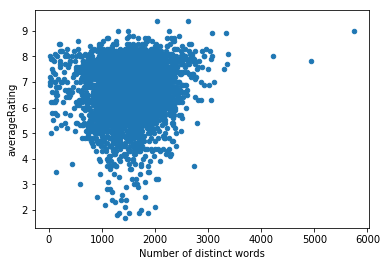

In [35]:
ax = df_words_ratings_pd.plot.scatter("Number of distinct words", "averageRating")

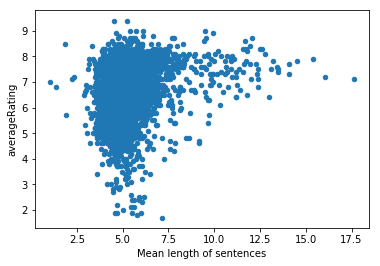

In [37]:
ax = df_words_ratings_pd.plot.scatter("Mean length of sentences", "averageRating")

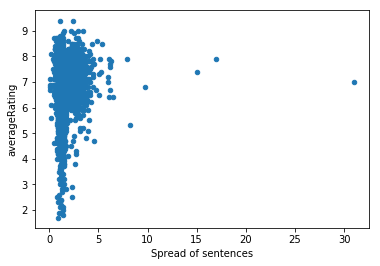

In [38]:
ax = df_words_ratings_pd.plot.scatter("Spread of sentences", "averageRating")

In [ ]:
df_filtered = df_ratings.filter(df_ratings.numVotes > 20000)
df_50_best = df_films.join(df_filtered, ["tconst"])\
                     .orderBy(df_ratings.averageRating.desc())\
                     .select("num_sentences", 
                             "averageRating", 
                             "numVotes", "year", "tconst")\
                     .take(50)

In [ ]:
#cest de la merde pour linstant vue la taille du dataset
df_pd_example = pd.DataFrame(df_50_best)

In [ ]:
df_pd_example